# Multivariate Time Series Clustering

### Inspired by https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering#3.-Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from datetime import timedelta

## Load data

In [2]:
# ts1_df = pd.read_csv('../data/devices1.csv')
# ts2_df = pd.read_csv('../data/devices2.csv')
# ts3_df = pd.read_csv('../data/devices3.csv')
# ts4_df = pd.read_csv('../data/devices4.csv')
# data = pd.concat([ts1_df, ts2_df, ts3_df, ts4_df], axis = 0, ignore_index = True)

data = pd.read_csv('../data/devices1.csv')
data = data.dropna()

In [3]:
data.head()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0
9,6.720,0.000,0.002,0.002,0.005,102.0,27.152667,2021-03-02 06:51:24,0.002,6.735,0
14,6.710,0.010,0.002,0.012,0.005,102.0,26.919203,2021-03-02 07:01:24,0.002,6.725,0
19,6.705,0.010,0.002,0.012,0.005,102.0,27.003891,2021-03-02 07:11:24,0.002,6.720,0
24,6.705,0.010,0.002,0.012,0.005,102.0,27.017624,2021-03-02 07:21:24,0.002,6.715,0


## Inputs

In [4]:
variables_to_analyse = ["battery_voltage", "current", "state_of_charge_percent", "temperature"]
frequency = "weekly"  # Either daily, weekly, monthly or seasonally
stat = "median"

## Battery Voltage Analysis

### Preprocessing

#### Data preparation

In [5]:
# Converting data timestamp in datetime objects
data.timestamp = pd.to_datetime(data.timestamp)

# Keeping only studied variables
data = data[["timestamp", "battery_id"] + variables_to_analyse]

# Setting date column as index
data.set_index("timestamp", inplace=True)

In [6]:
data = data.groupby("battery_id").resample("10min").mean()

In [7]:
data = data.drop("battery_id", axis=1)
data = data.reset_index().set_index("timestamp")

#### Grouping data by battery id

In [8]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

list_datetime_starting_week = data.resample("W-MON")["current"].median().index.date

k=1
selected_week_start = list_datetime_starting_week[k]

# df = data.loc[str(selected_week_start):str(selected_week_start+timedelta(days=6))]
df = data
df["day_of_week"] = df.index.day_of_week
df["hour"] = df.index.hour
df["minute"] = df.index.minute

In [9]:
df.head()

,battery_id,battery_voltage,current,state_of_charge_percent,temperature,day_of_week,hour,minute
timestamp,,,,,,,,
2021-03-02 06:40:00,0,7.0750,-2.276,100.0,28.287938,1,6,40
2021-03-02 06:50:00,0,6.7200,0.000,102.0,27.152667,1,6,50
2021-03-02 07:00:00,0,6.7100,0.010,102.0,26.919203,1,7,0
2021-03-02 07:10:00,0,6.7050,0.010,102.0,27.003891,1,7,10
2021-03-02 07:20:00,0,6.7025,0.013,102.0,27.096590,1,7,20


In [10]:
# df1 = df.groupby(["battery_id", "day_of_week", "hour", "minute"]).mean()
df1 = df.groupby(["battery_id", "day_of_week", "hour", "minute"]).agg(["mean", percentile(25)])  # , percentile(75), percentile(99)]
df1.head(20)

battery_voltage                 current  \
                                              mean percentile_25      mean   
battery_id day_of_week hour minute                                           
0          0           0    0             6.522656      6.495000  0.524500   
                            10            6.522656      6.495000  0.519500   
                            20            6.523125      6.495000  0.511625   
                            30            6.522500      6.493750  0.508438   
                            40            6.520625      6.490000  0.513875   
                            50            6.520937      6.490000  0.510375   
                       1    0             6.519687      6.490000  0.508500   
                            10            6.518281      6.485000  0.505687   
                            20            6.517188      6.485000  0.507250   
                            30            6.516562      6.485000  0.504750   
                            40            6.514687      6.480000  0.507125   
                            50            6.513750      6.480000  0.506437   
                       2    0             6.511563      6.476875  0.504500   
                            10            6.509688      6.475000  0.509250   
                            20            6.507500      6.470000  0.505938   
                            30            6.506875      6.470000  0.497500   
                            40            6.499688      6.465000  0.530812   
                            50            6.497813      6.465000  0.527500   
                       3    0             6.493437      6.460000  0.539625   
                            10            6.490312      6.458750  0.537750   

                                                 state_of_charge_percent  \
                                   percentile_25                    mean   
battery_id day_of_week hour minute                                         
0          0           0    0             0.4235                62.21875   
                            10            0.4175                61.50000   
                            20            0.3920                60.56250   
                            30            0.3920                59.65625   
                            40            0.4490                58.84375   
                            50            0.4325                57.93750   
                       1    0             0.4235                56.96875   
                            10            0.4070                56.03125   
                            20            0.3915                55.31250   
                            30            0.3920                54.43750   
                            40            0.3920                53.62500   
                            50            0.3920                52.78125   
                       2    0             0.3920                52.03125   
                            10            0.3920                51.12500   
                            20            0.3915                50.25000   
                            30            0.3935                49.40625   
                            40            0.3935                48.50000   
                            50            0.3920                47.53125   
                       3    0             0.3935                46.68750   
                            10            0.3935                45.59375   

                                                 temperature                
                                   percentile_25        mean percentile_25  
battery_id day_of_week hour minute                                          
0          0           0    0             54.750   25.077749     24.409190  
                            10            53.750   25.062943     24.359693  
                            20            52.750   25.018454     24.296750  
                            3

In [11]:
df.head(20)

,battery_id,battery_voltage,current,state_of_charge_percent,temperature,day_of_week,hour,minute
timestamp,,,,,,,,
2021-03-02 06:40:00,0,7.0750,-2.276,100.0,28.287938,1,6,40
2021-03-02 06:50:00,0,6.7200,0.000,102.0,27.152667,1,6,50
2021-03-02 07:00:00,0,6.7100,0.010,102.0,26.919203,1,7,0
2021-03-02 07:10:00,0,6.7050,0.010,102.0,27.003891,1,7,10
2021-03-02 07:20:00,0,6.7025,0.013,102.0,27.096590,1,7,20
2021-03-02 07:30:00,0,6.7000,0.010,102.0,26.894026,1,7,30
2021-03-02 07:40:00,0,6.7000,0.010,101.0,26.843671,1,7,40
2021-03-02 07:50:00,0,6.7000,0.010,101.0,27.090867,1,7,50
2021-03-02 08:00:00,0,6.6950,0.010,101.0,27.397574,1,8,0


In [12]:
df1 = df1.reset_index()
df1

battery_id day_of_week hour minute battery_voltage                \
                                                    mean percentile_25   
0              0           0    0      0        6.522656       6.49500   
1              0           0    0     10        6.522656       6.49500   
2              0           0    0     20        6.523125       6.49500   
3              0           0    0     30        6.522500       6.49375   
4              0           0    0     40        6.520625       6.49000   
...          ...         ...  ...    ...             ...           ...   
50395         49           6   23     10        6.566196           NaN   
50396         49           6   23     20        6.561591           NaN   
50397         49           6   23     30        6.561087           NaN   
50398         49           6   23     40        6.558261           NaN   
50399         49           6   23     50        6.556087           NaN   

        current               state_of_charge_percent                \
           mean percentile_25                    mean percentile_25   
0      0.524500        0.4235               62.218750         54.75   
1      0.519500        0.4175               61.500000         53.75   
2      0.511625        0.3920               60.562500         52.75   
3      0.508438        0.3920               59.656250         51.75   
4      0.513875        0.4490               58.843750         50.75   
...         ...           ...                     ...           ...   
50395  0.382304           NaN               61.891304           NaN   
50396  0.382364           NaN               60.545455           NaN   
50397  0.382696           NaN               60.586957           NaN   
50398  0.382870           NaN               60.000000           NaN   
50399  0.382957           NaN               59.217391           NaN   

      temperature                
             mean percentile_25  
0       25.077749     24.409190  
1       25.062943     24.359693  
2       25.018454     24.296750  
3       24.980330     24.275006  
4       24.965310     24.237240  
...           ...           ...  
50395   22.835193           NaN  
50396   22.793233           NaN  
50397   22.755182           NaN  
50398   22.718013           NaN  
50399   22.675172           NaN  

[50400 rows x 12 columns]

In [13]:
df1

battery_id day_of_week hour minute battery_voltage                \
                                                    mean percentile_25   
0              0           0    0      0        6.522656       6.49500   
1              0           0    0     10        6.522656       6.49500   
2              0           0    0     20        6.523125       6.49500   
3              0           0    0     30        6.522500       6.49375   
4              0           0    0     40        6.520625       6.49000   
...          ...         ...  ...    ...             ...           ...   
50395         49           6   23     10        6.566196           NaN   
50396         49           6   23     20        6.561591           NaN   
50397         49           6   23     30        6.561087           NaN   
50398         49           6   23     40        6.558261           NaN   
50399         49           6   23     50        6.556087           NaN   

        current               state_of_charge_percent                \
           mean percentile_25                    mean percentile_25   
0      0.524500        0.4235               62.218750         54.75   
1      0.519500        0.4175               61.500000         53.75   
2      0.511625        0.3920               60.562500         52.75   
3      0.508438        0.3920               59.656250         51.75   
4      0.513875        0.4490               58.843750         50.75   
...         ...           ...                     ...           ...   
50395  0.382304           NaN               61.891304           NaN   
50396  0.382364           NaN               60.545455           NaN   
50397  0.382696           NaN               60.586957           NaN   
50398  0.382870           NaN               60.000000           NaN   
50399  0.382957           NaN               59.217391           NaN   

      temperature                
             mean percentile_25  
0       25.077749     24.409190  
1       25.062943     24.359693  
2       25.018454     24.296750  
3       24.980330     24.275006  
4       24.965310     24.237240  
...           ...           ...  
50395   22.835193           NaN  
50396   22.793233           NaN  
50397   22.755182           NaN  
50398   22.718013           NaN  
50399   22.675172           NaN  

[50400 rows x 12 columns]

In [14]:
df1 = df1.apply(lambda x: x.fillna(x.mean()))
df1

battery_id day_of_week hour minute battery_voltage                \
                                                    mean percentile_25   
0              0           0    0      0        6.522656      6.495000   
1              0           0    0     10        6.522656      6.495000   
2              0           0    0     20        6.523125      6.495000   
3              0           0    0     30        6.522500      6.493750   
4              0           0    0     40        6.520625      6.490000   
...          ...         ...  ...    ...             ...           ...   
50395         49           6   23     10        6.566196      6.626361   
50396         49           6   23     20        6.561591      6.626361   
50397         49           6   23     30        6.561087      6.626361   
50398         49           6   23     40        6.558261      6.626361   
50399         49           6   23     50        6.556087      6.626361   

        current               state_of_charge_percent                \
           mean percentile_25                    mean percentile_25   
0      0.524500      0.423500               62.218750     54.750000   
1      0.519500      0.417500               61.500000     53.750000   
2      0.511625      0.392000               60.562500     52.750000   
3      0.508438      0.392000               59.656250     51.750000   
4      0.513875      0.449000               58.843750     50.750000   
...         ...           ...                     ...           ...   
50395  0.382304     -0.177506               61.891304     67.460368   
50396  0.382364     -0.177506               60.545455     67.460368   
50397  0.382696     -0.177506               60.586957     67.460368   
50398  0.382870     -0.177506               60.000000     67.460368   
50399  0.382957     -0.177506               59.217391     67.460368   

      temperature                
             mean percentile_25  
0       25.077749     24.409190  
1       25.062943     24.359693  
2       25.018454     24.296750  
3       24.980330     24.275006  
4       24.965310     24.237240  
...           ...           ...  
50395   22.835193     26.434773  
50396   22.793233     26.434773  
50397   22.755182     26.434773  
50398   22.718013     26.434773  
50399   22.675172     26.434773  

[50400 rows x 12 columns]

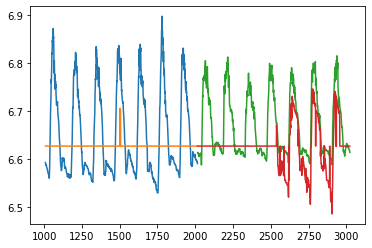

In [15]:
plt.plot(df1.loc[(df1.battery_id==1)].battery_voltage)
plt.plot(df1.loc[(df1.battery_id==2)].battery_voltage)
plt.show()

In [16]:
bat_df = []  # List to store every battery dataframe

for i in range(len(df1.battery_id.unique())):
    bat_df.append(df1.loc[df1.battery_id == i][variables_to_analyse])  # Storing specific battery id dataframe

#### Standardizing size

##### Finding longest time series

In [17]:
series_lengths = {len(series) for series in bat_df}  # Serie length of every battery dataframe
max_len = max(series_lengths)  # max lenght amongst all series
longest_series = None

for series in bat_df:
    if len(series) == max_len:
        longest_series = series

##### Normalizing size

In [18]:
longest_series = longest_series.reset_index(drop=True)

In [19]:
problems_index = []  # Finding battery indexes that need to be re-indexed to the longest time serie

for i in range(1, len(bat_df)):
    # Time series that aren't as long as the largest one need to be reindexed
    if len(bat_df[i]) != max_len:
        problems_index.append(i)
        # Values are reindexed to the nearest (1 min tolerance) time index of the longest time serie
        bat_df[i] = bat_df[i].reset_index(drop=True)
        bat_df[i] = bat_df[i].reindex(index=longest_series.index, method='nearest')

In [20]:
for i in range(1, len(bat_df)):
    bat_df[i] = bat_df[i].reset_index(drop=True)
    bat_df[i] = bat_df[i].reindex(index=longest_series.index, method='nearest')

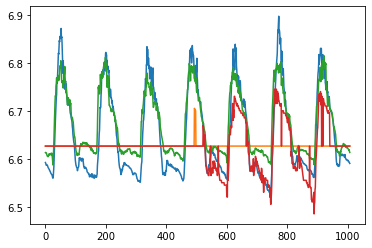

In [21]:
plt.plot(bat_df[1].battery_voltage)
plt.plot(bat_df[2].battery_voltage)
plt.show()

##### Dealing with NaN values

In [22]:
# Values who couldn't be reindexed or gaps are filled using interpolation
for i in range(1, len(bat_df)):
    bat_df[i].interpolate(limit_direction="both", inplace=True)

bat_df = bat_df[1:]

### K-means clustering

#### Choosing number of clusters

In [23]:
distortions = []
K = range(1,10)

for k in K:
    km = TimeSeriesKMeans(n_clusters=k, metric="euclidean")
    labels = km.fit_predict(bat_df)
    distortions.append(km.inertia_)

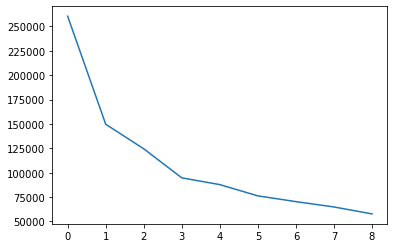

In [24]:
plt.plot(distortions)

In [25]:
cluster_count = 4

#### Fit k-means clustering

In [26]:
# Time series specific clustering algorithm
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean")  # dtw metric takes way too long...

# Predict closest cluster for each time series
labels = km.fit_predict(bat_df)

##### Results

In [27]:
# # Larger plots showing inline
# plt.rcParams["figure.figsize"] = (20,15)

# fig, axs = plt.subplots(len(set(labels)))
# fig.tight_layout()

# variable_to_plot = "battery_voltage"

# for label in set(labels):
#     for i in range(len(data.battery_id.unique())):
#         if(labels[i]==label):
#             axs[label].set_title("Cluster {}".format(label))
#             axs[label].set_ylabel(variable_to_plot)
#             axs[label].plot(bat_df[i][variable_to_plot], c="gray", alpha=0.4)
# #     axs[label].plot(longest_series.index, km.cluster_centers_[label], c="red")
# plt.xlabel("Time")
# plt.subplots_adjust(hspace=0.5)

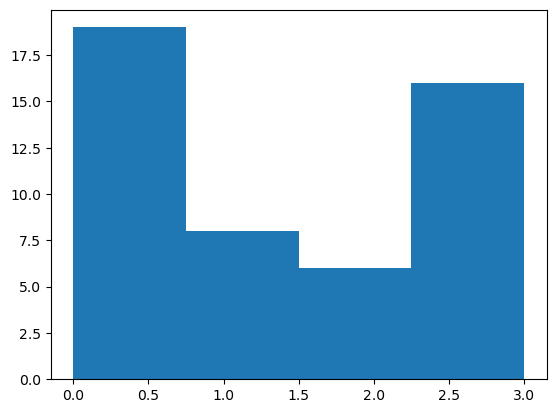

In [28]:
# Reseting stylesheet
plt.rcParams.update(plt.rcParamsDefault)

# Distribution of time series in clusters
plt.hist(labels, bins=cluster_count)
plt.show()

In [29]:
col_name_lvl_0 = df1.columns.get_level_values(0)
col_name_lvl_1 = df1.columns.get_level_values(1)
output_col_name = col_name_lvl_0[4:] + "_" + col_name_lvl_1[4:]

output_df = []
clu_id = 0

for clu in km.cluster_centers_:
    tempDf = pd.DataFrame(clu, columns=output_col_name)
    tempDf["cluster_id"] = clu_id
    clu_id += 1
    output_df.append(tempDf)

In [30]:
output_df = pd.concat(output_df)
output_df

,battery_voltage_mean,battery_voltage_percentile_25,current_mean,current_percentile_25,state_of_charge_percent_mean,state_of_charge_percent_percentile_25,temperature_mean,temperature_percentile_25,cluster_id
0,6.571801,6.552117,0.316163,0.217894,61.757920,56.811618,26.795559,26.139060,0
1,6.570198,6.554557,0.314760,0.189604,61.223158,56.552953,26.758053,26.290393,0
2,6.569504,6.551985,0.310575,0.203973,60.680675,55.719512,26.720176,26.080123,0
3,6.568220,6.551262,0.309461,0.203052,60.157799,55.180039,26.686939,26.045790,0
4,6.567196,6.551031,0.307068,0.203184,59.637959,54.587933,26.650411,26.031213,0
...,...,...,...,...,...,...,...,...,...
1003,6.583701,6.626361,0.253719,-0.177506,67.700660,67.460368,26.153261,26.434773,3
1004,6.582667,6.626361,0.250137,-0.177506,67.204810,67.460368,26.111803,26.434773,3
1005,6.581617,6.626361,0.248466,-0.177506,66.874733,67.460368,26.072998,26.434773,3
1006,6.580918,6.626361,0.244227,-0.177506,66.394893,67.460368,26.032140,26.434773,3


In [31]:
df2 = df1.loc[df1.battery_id==0]
df2["timestamp"] = df2.day_of_week.astype(str) + " " + df2.hour.astype(str) + ":" + df2.minute.astype(str)
df2.timestamp

<ipython-input-31-dc9e4b39a3ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["timestamp"] = df2.day_of_week.astype(str) + " " + df2.hour.astype(str) + ":" + df2.minute.astype(str)


0         0 0:0
1        0 0:10
2        0 0:20
3        0 0:30
4        0 0:40
         ...   
1003    6 23:10
1004    6 23:20
1005    6 23:30
1006    6 23:40
1007    6 23:50
Name: timestamp, Length: 1008, dtype: object

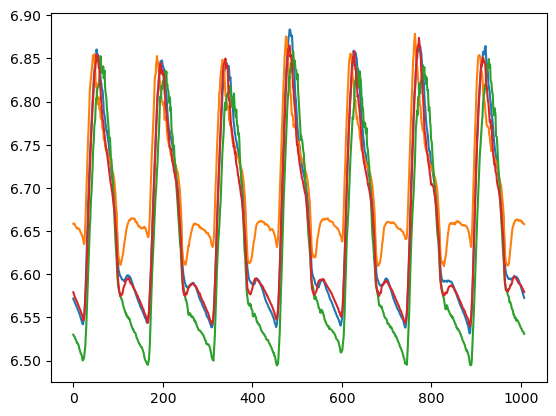

In [32]:
for clu_id in range(len(output_df.cluster_id.unique())):
    plt.plot(output_df[output_df.cluster_id==clu_id].battery_voltage_mean)

In [33]:
output_df.to_csv("multivariate_time_series_clustering_{}.csv".format(frequency))

In [34]:
output_df.head()

,battery_voltage_mean,battery_voltage_percentile_25,current_mean,current_percentile_25,state_of_charge_percent_mean,state_of_charge_percent_percentile_25,temperature_mean,temperature_percentile_25,cluster_id
0,6.571801,6.552117,0.316163,0.217894,61.757920,56.811618,26.795559,26.139060,0
1,6.570198,6.554557,0.314760,0.189604,61.223158,56.552953,26.758053,26.290393,0
2,6.569504,6.551985,0.310575,0.203973,60.680675,55.719512,26.720176,26.080123,0
3,6.568220,6.551262,0.309461,0.203052,60.157799,55.180039,26.686939,26.045790,0
4,6.567196,6.551031,0.307068,0.203184,59.637959,54.587933,26.650411,26.031213,0
